# Small and shallow networks

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import sys
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras import callbacks, optimizers

#### Parameters

In [ ]:
use_mcmc=True
# Number of epochs
epochs=50000

# Number of hidden units for the single hidden layer
num_hidden_units=3

# Number of samples psi to approximate the expected value
#num_samples_per_epoch=6

# Range for the PPD
num_xx=500
xx = np.linspace(-10, 10, num_xx).reshape(-1, 1)

# Number of predictions for the PPD
num_predictions=1000

optimizers = optimizers.RMSprop()

In [ ]:
%load_ext autoreload
%autoreload 2


try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vigauss_keras.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_keras.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_utils_keras.py
    !wget https://github.com/stefan1893/TM-VI/blob/main/ipynb/02_small_and_shallow_networks.npz?raw=true -O 02_small_and_shallow_networks.npz

    sys.path.append(".")
    import vimlts_utils_keras as VIMLTS_utils
    from vimlts import VIMLTS
    from vigauss_keras import DenseVIGAUSS
    from vimlts_keras import DenseVIMLTS
except:
    IN_COLAB = False
    sys.path.append('../')
    import src.vimlts_utils_keras as VIMLTS_utils
    from src.vimlts import VIMLTS
    from src.vigauss_keras import DenseVIGAUSS
    from src.vimlts_keras import DenseVIMLTS
    #Use GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_probability as tfp
import tensorflow.keras as keras
import pandas as pd
import pystan
import scipy.stats as stats
import scipy.signal
import seaborn as sns
import tqdm
import datetime
import sys
import ctypes
import pickle
from IPython.display import display, clear_output, HTML
from numpy import trapz
from scipy.stats import norm


tfd=tfp.distributions

print('Tensorflow version: ',tf.__version__, )

--2021-09-23 08:52:38--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8100 (7.9K) [text/plain]
Saving to: ‘vimlts.py’

vimlts.py           100%[===================>]   7.91K  --.-KB/s    in 0s      

2021-09-23 08:52:38 (56.4 MB/s) - ‘vimlts.py’ saved [8100/8100]

--2021-09-23 08:52:38--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vigauss_keras.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6608 (6.5K) [text/plain]
Saving to: ‘vigauss_ker

## Data generating process

In [ ]:
def get_toy_data_3(
    noise_scale,
    train_size,
    test_size,
    true_size,
    use_hole
):
    tf.random.set_seed(2)

    train_xlim = 6.
    test_xlim = 6.5
    true_xlim = 6.5

    # True function
    target_fn = lambda x: np.sin(x)

    # Train samples
    if use_hole:
        half_train_size = train_size // 2
        train_xs_left = tfd.Uniform(low = -train_xlim, high = -train_xlim/3).sample(sample_shape = (half_train_size, 1))
        train_xs_right = tfd.Uniform(low = train_xlim/3, high = train_xlim).sample(sample_shape = (half_train_size, 1))
        train_xs = np.concatenate((train_xs_left, train_xs_right))
    else:
        train_xs = np.linspace(-train_xlim,train_xlim,train_size)
        train_xs = np.reshape(train_xs,[-1,1])


    train_ys = target_fn(train_xs)
    train_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (train_size, 1))

    # Test samples
    test_xs = np.linspace(-test_xlim,test_xlim,test_size)
    test_xs = np.reshape(test_xs,[-1,1])
    test_ys = target_fn(test_xs)
    test_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (test_size, 1))

    # True
    true_xs = np.linspace(-true_xlim, true_xlim, true_size)
    true_xs = np.reshape(true_xs, (true_size, 1))
    true_ys = target_fn(true_xs)


    return train_xs, train_ys, test_xs, test_ys, true_xs, true_ys

load data


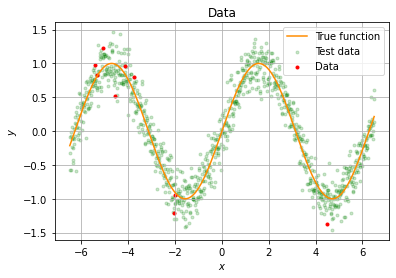

In [ ]:
sigma = noise  = .2
num = train_size = 9
test_size = 1000
true_size = 1000

data_file = "02_small_and_shallow_networks.npz"
try:
    def unpack(x, y, x_test, y_test, x_true, y_true):
        return x, y, x_test, y_test, x_true, y_true
    x, y, x_test, y_test, x_true, y_true = unpack(**np.load(data_file))
    x = x[0:9, ] #<--- Only 9
    y = y[0:9]
    print("load data")
except Exception as e:
    print("create data")
    print(e)
    x, y, x_test, y_test, x_true, y_true = get_toy_data_3(sigma, train_size, test_size, true_size,use_hole=1)
    np.savez(data_file, x=x,y=y,x_test=x_test, y_test=y_test, x_true=x_true ,y_true=y_true)
y=np.reshape(y,[-1])
y_test=np.reshape(y_test,[-1])

plt.figure()
plt.scatter(x_test,y_test, marker='.', color='g',label=r"Test data",alpha=0.2)
plt.scatter(x,y, marker='.', color='r',label=r"Data")
plt.plot(x_true,y_true,color="darkorange",label=r"True function")
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Data');

In [ ]:
len(y)

9

## Common hyperparameter

In [ ]:
# Train parameters
batch_size = train_size
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches

# Prior
prior_params = {
    'prior_mu': 0., 
    'prior_sigma': 1.
}

## Common functions

In [ ]:
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

## Ground truth


In [ ]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [ ]:
if use_mcmc:
  stan_code = """
  functions {
    matrix selfmade_relu(matrix z, int a_rows, int a_columns){
      matrix[a_rows, a_columns] a;
      for (i in 1:a_rows){
        for (j in 1:a_columns){
          if(z[i,j]>0){
            a[i,j]=z[i,j];
          }
          else{
            a[i,j]=0;
          }
        }
      }
      return a;
    }
    
    vector calculate_mu(matrix X, matrix bias_first_m, real bias_output, matrix w_first, vector w_output, int num_layers) {
		int N = rows(X);
		int num_nodes = rows(w_first);

		matrix[N, num_nodes] layer_values[num_layers - 2];
		vector[N] mu;

		//layer_values[1] = selfmade_relu(bias_first_m + X * w_first',N,num_nodes);  
    layer_values[1] = inv_logit(bias_first_m + X * w_first');   

		mu = bias_output + layer_values[num_layers - 2] * w_output;

      return mu;
    }
  }
  data {
    int<lower=0> N;						// num data
    int<lower=0> d;						// dim x
    int<lower=0> num_nodes;				// num hidden unites
    int<lower=1> num_middle_layers;		// num hidden layer
    matrix[N,d] X;						// X
    real y[N];							// y
	int<lower=0> Nt;					// num predicive data
	matrix[Nt,d] Xt;					// X predicive
	real<lower=0> sigma;				// const sigma
  }
  transformed data {
    int num_layers;
    num_layers = num_middle_layers + 2;
  }
  parameters {
    vector[num_nodes] bias_first;
    real bias_output;
    matrix[num_nodes, d] w_first;
    vector[num_nodes] w_output;
	// hyperparameters
    real<lower=0> bias_first_h;
    real<lower=0> w_first_h;
    real<lower=0> w_output_h;
  } 
  transformed parameters {
    matrix[N, num_nodes] bias_first_m = rep_matrix(bias_first', N);
  }
  model{
    vector[N] mu;
    mu = calculate_mu(X, bias_first_m, bias_output, w_first, w_output, num_layers);
    y ~ normal(mu,sigma);
    
    //priors
    bias_first_h ~ normal(0, 1);
    bias_first ~ normal(0, 1);
    bias_output ~ normal(0, 1);

    w_first_h ~ normal(0, 1);
    to_vector(w_first) ~ normal(0, 1);

    w_output_h ~ normal(0, 1);
    w_output ~ normal(0, 1);
  }
  generated quantities{
    vector[Nt] predictions;
	matrix[Nt, num_nodes] bias_first_mg = rep_matrix(bias_first', Nt);
	vector[Nt] mu;

	mu = calculate_mu(Xt, bias_first_mg, bias_output,w_first, w_output, num_layers);
	for(i in 1:Nt){ 
		predictions[i] = normal_rng(mu[i],sigma);
	}
  }
  """
  model_mcmc=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb4992f066e706ad7835e6d9163a9f06 NOW.


In [ ]:
num_hidden_units

3

In [ ]:
if use_mcmc:
  my_dat = {'N': num,
          'd': 1,
          'num_nodes': num_hidden_units,
          'num_middle_layers':1,
          'X': x,
          'y': y,
          'sigma': sigma,
          'Nt': num_xx,
          'Xt': xx
          }

  fit_mcmc=model_mcmc.sampling(data=my_dat,iter=5000,chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
if use_mcmc:    
    samples_predictions=fit_mcmc.extract()['predictions']; 
    print(samples_predictions.shape)
    samples_predictions_mean=np.mean(samples_predictions,axis=0)
    samples_predictions_2p5=np.quantile(samples_predictions,0.025,axis=0)
    samples_predictions_97p5=np.quantile(samples_predictions,0.975,axis=0)
    samples_predictions_50p0=np.quantile(samples_predictions,0.5,axis=0)

(10000, 500)


In [ ]:
if use_mcmc:    
  import pandas as pd
  df = pd.DataFrame(data=[xx.ravel(),samples_predictions_mean, 
                   samples_predictions_2p5, 
                   samples_predictions_50p0, 
                   samples_predictions_97p5])
  df.transpose().to_csv('mcmc_y_quantiles.csv')

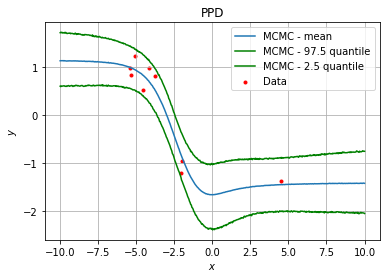

In [ ]:
if use_mcmc:
    plt.plot(xx,samples_predictions_mean,label="MCMC - mean")
    plt.plot(xx,samples_predictions_97p5,color='g',label="MCMC - 97.5 quantile")
    #plt.plot(xx,samples_predictions_50p0,color='g',label="mcmc_50p0_quantile")
    plt.plot(xx,samples_predictions_2p5,color='g',label="MCMC - 2.5 quantile")
    plt.scatter(x,y, marker='.', color='r', label="Data")
    plt.legend()
    plt.grid()
    plt.ylabel(r"$y$")
    plt.xlabel(r"$x$")
    plt.title(r'PPD');

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


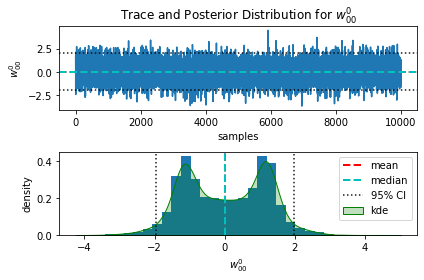

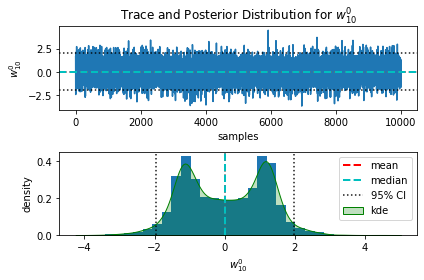

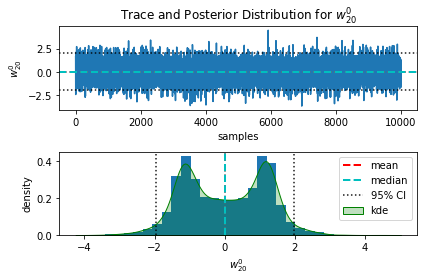

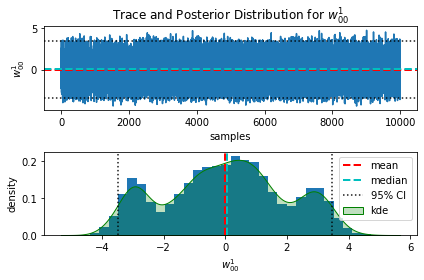

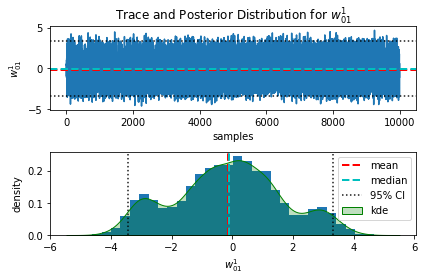

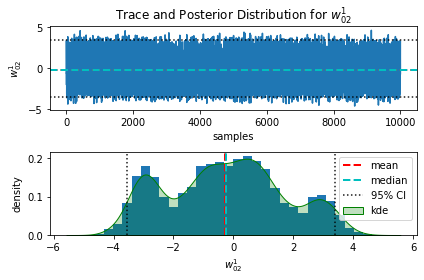

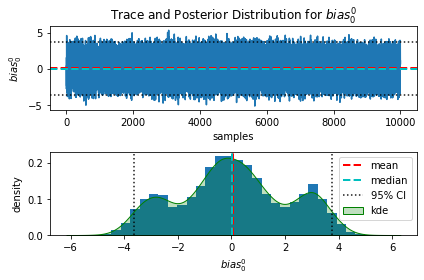

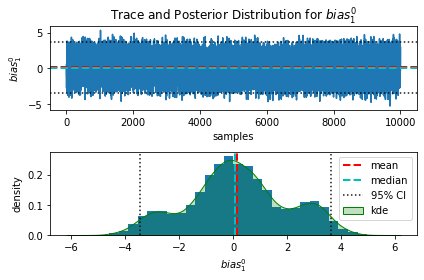

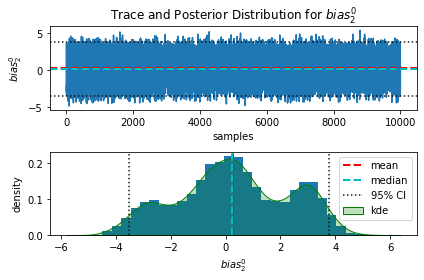

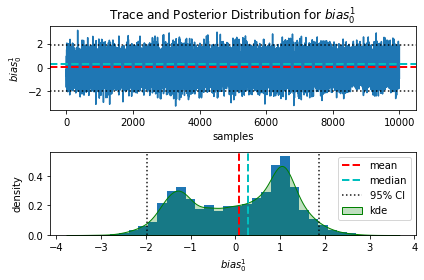

In [ ]:
if use_mcmc:
    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_first'][:,0,0],r"$w^{0}_{"+str(i)+r"0}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_output'][:,i],r"$w^{1}_{0"+str(i)+r"}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['bias_first'][:,i],r"$bias^{0}_{"+str(i)+r"}$")

    plt.figure()
    plot_trace(fit_mcmc.extract()['bias_output'],r"$bias^{1}_{0}$")

## VIGAUSS

MFVI with a Gaussian as variational distribution

In [ ]:
x_in = Input(shape=(1,),name="VIGAUSS_il")
x_arch = DenseVIGAUSS(units=num_hidden_units, activation='sigmoid', kl_weight=kl_weight, name="VIGAUSS_hl_1", **prior_params )(x_in)
x_arch = DenseVIGAUSS(units=1, kl_weight=kl_weight, name="VIGAUSS_ol", **prior_params)(x_arch)

model_VIGAUSS = Model(x_in, x_arch,name="model_VIGAUSS")

In [ ]:
print(model_VIGAUSS.summary())

Model: "model_VIGAUSS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VIGAUSS_il (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
VIGAUSS_hl_1 (DenseVIGAUSS)  (None, 3)                 12        
_________________________________________________________________
VIGAUSS_ol (DenseVIGAUSS)    (None, 1)                 8         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers, metrics=[neg_log_likelihood])

In [ ]:
callbacks_VIGAUSS = [
    #callbacks.LearningRateScheduler(lr_scheduler, verbose=0)
]

# Fit the model to the data
hist=model_VIGAUSS.fit(x, y, callbacks=callbacks_VIGAUSS, batch_size=batch_size, epochs=epochs, verbose=0);

## VIMLTS

MFVI with a flexible variational distribution

### functions

In [ ]:
def get_lambdas_for_w(layer_weights, from_neuron_layer_bevore, to_neuron):
    """
        Gets the variational parameter for a specific weight
    """  
    try:
        num_param=14
        lambdas=[]
        
        for j in range(int(num_param)):
            lambdas.append(layer_weights[j][from_neuron_layer_bevore][to_neuron])
        return lambdas
    except:
        print("Constellation not existing")


def get_lambdas_for_bias(layer_weights, neuron):
    """
        Gets the variational parameter for a specific bias
    """  
    try:
        num_param=14
        lambdas=[]
 
        for j in range(num_param,num_param*2):
            lambdas.append(layer_weights[j][neuron])
        return lambdas
    except:
        print("Constellation not existing")

In [ ]:
x_in = Input(shape=(1,),name="VIMLTS_il")
x_arch = DenseVIMLTS(units=num_hidden_units, 
                    activation='sigmoid', 
                    kl_weight=kl_weight, 
                    init_gauss_like=False,
                    using_f3=True,
                    name="VIMLTS_hl_1", **prior_params)(x_in)
x_arch = DenseVIMLTS(units=1, 
                    kl_weight=kl_weight, 
                    init_gauss_like=False,
                    using_f3=True,
                    name="VIMLTS_ol", **prior_params)(x_arch)
model_VIMLTS = Model(x_in, x_arch,name="model_VIMLTS")

Tensor("VIMLTS_hl_1/concat_8:0", shape=(10, 1, 3), dtype=float32)
Tensor("VIMLTS_ol/concat_8:0", shape=(10, 3, 1), dtype=float32)


In [ ]:
print(model_VIMLTS.summary())

Model: "model_VIMLTS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VIMLTS_il (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
VIMLTS_hl_1 (DenseVIMLTS)    (None, 3)                 84        
_________________________________________________________________
VIMLTS_ol (DenseVIMLTS)      (None, 1)                 56        
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_VIMLTS.compile(loss=neg_log_likelihood, optimizer=optimizers, metrics=[neg_log_likelihood])

In [ ]:
# Number of checkpoints, to save the variational distribution during the training
checkpoints=50

subepochs=int(epochs/checkpoints)
hist_weights=[]

class callback_save_weights(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # true
        if(epoch%subepochs==0):
            print("checkpoint:\t",int(epoch/subepochs),"\tloss:\t",logs["loss"])
            layer_weights=[]
            for layer in range(np.shape(self.model.layers)[0]):
                layer_weights.append(self.model.layers[layer].get_weights()[:])

            hist_weights.append(layer_weights)


callbacks_VIMLTS = [
        callback_save_weights()
]

# Fit the model to the data
hist_VIMLTS=model_VIMLTS.fit(x, y, callbacks=callbacks_VIMLTS, batch_size=batch_size, epochs=epochs, verbose=0)

Tensor("model_VIMLTS/VIMLTS_hl_1/concat_8:0", shape=(10, 1, 3), dtype=float32)
Tensor("model_VIMLTS/VIMLTS_ol/concat_8:0", shape=(10, 3, 1), dtype=float32)
Tensor("model_VIMLTS/VIMLTS_hl_1/concat_8:0", shape=(10, 1, 3), dtype=float32)
Tensor("model_VIMLTS/VIMLTS_ol/concat_8:0", shape=(10, 3, 1), dtype=float32)
checkpoint:	 0 	loss:	 759.3023071289062
checkpoint:	 1 	loss:	 1175.6866455078125
checkpoint:	 2 	loss:	 110.89932250976562
checkpoint:	 3 	loss:	 104.09147644042969
checkpoint:	 4 	loss:	 59.21174621582031
checkpoint:	 5 	loss:	 42.02592849731445
checkpoint:	 6 	loss:	 34.405799865722656
checkpoint:	 7 	loss:	 26.191516876220703
checkpoint:	 8 	loss:	 36.55975341796875
checkpoint:	 9 	loss:	 31.454715728759766
checkpoint:	 10 	loss:	 27.823204040527344
checkpoint:	 11 	loss:	 29.03153419494629
checkpoint:	 12 	loss:	 27.816669464111328
checkpoint:	 13 	loss:	 28.3583927154541
checkpoint:	 14 	loss:	 38.71514892578125
checkpoint:	 15 	loss:	 31.04758644104004
checkpoint:	 16 	lo

## Analyse the run

### Analyse the loss

Minimum Loss VIMLTS:		 13.078624725341797
Minimum Loss VIMLTS an Epoche:	 45196
Loss nach Training VIMLTS:	 25.556787490844727
Loss nach Training VIGAUSS:	 25.88860511779785


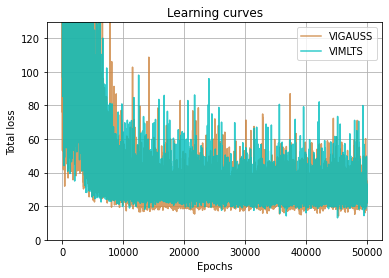

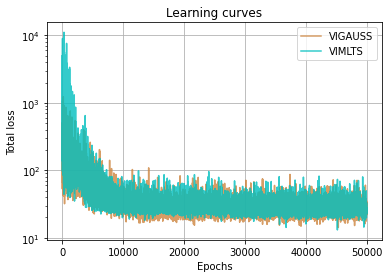

In [ ]:
loss_model_VIGAUSS=hist.history['loss'][np.shape(hist.history['loss'])[0]-1]
loss_model_VIMLTS=hist_VIMLTS.history['loss'][np.shape(hist_VIMLTS.history['loss'])[0]-1]
loss_min_VIMLTS=np.min(hist_VIMLTS.history['loss'])
loss_min_epoche_VIMLTS=np.argmin(hist_VIMLTS.history['loss'])

print("Minimum Loss VIMLTS:\t\t",loss_min_VIMLTS)
print("Minimum Loss VIMLTS an Epoche:\t",loss_min_epoche_VIMLTS)
print("Loss nach Training VIMLTS:\t",loss_model_VIMLTS)
print("Loss nach Training VIGAUSS:\t",loss_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['loss'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.ylim([0, loss_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['loss'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.yscale('log')


Show a noise reduced curve

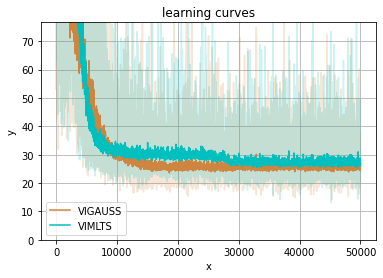

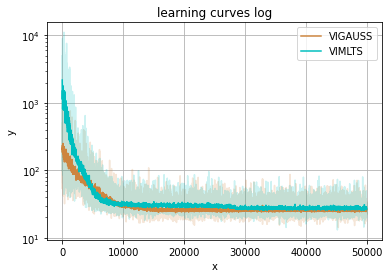

In [ ]:
loss_VIGAUSS_hat = scipy.signal.savgol_filter(hist.history['loss'], 31, 1) # window size 31, polynomial order 1
loss_VIMLTS_hat = scipy.signal.savgol_filter(hist_VIMLTS.history['loss'], 31, 1) # window size 31, polynomial order 1

title=r"learning curves"
plt.figure()
plt.plot(hist.history['loss'],color='peru',alpha=0.2)
plt.plot(hist_VIMLTS.history['loss'],color='c',alpha=0.2)
plt.plot(loss_VIGAUSS_hat,color='peru',label=r"VIGAUSS")
plt.plot(loss_VIMLTS_hat,color='c',label=r"VIMLTS")
plt.ylim([0, loss_model_VIMLTS*3])
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.title(title)
plt.show()

title=r"learning curves log"
plt.figure()
plt.plot(hist.history['loss'],color='peru',alpha=0.2)
plt.plot(hist_VIMLTS.history['loss'],color='c',alpha=0.2)
plt.plot(loss_VIGAUSS_hat,color='peru',label=r"VIGAUSS")
plt.plot(loss_VIMLTS_hat,color='c',label=r"VIMLTS")
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.yscale('log')
plt.title(title)
plt.show()

### Analyse the NLL

Minimum NLL VIMLTS:		 -0.8205332159996033
Minimum NLL VIMLTS an Epoche:	 25312
NLL nach Training VIMLTS:	 2.415566921234131
NLL nach Training VIGAUSS:	 3.1223692893981934


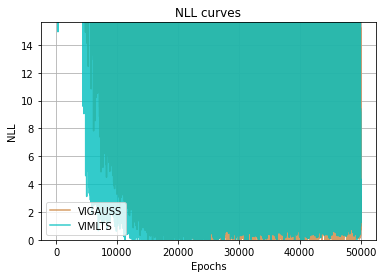

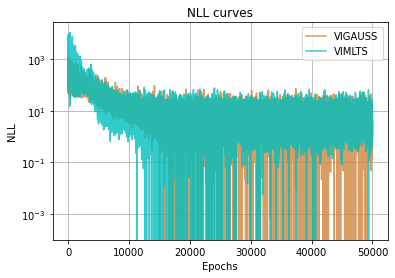

In [ ]:
NLL_model_VIGAUSS=hist.history['neg_log_likelihood'][np.shape(hist.history['neg_log_likelihood'])[0]-1]
NLL_model_VIMLTS=hist_VIMLTS.history['neg_log_likelihood'][np.shape(hist_VIMLTS.history['neg_log_likelihood'])[0]-1]
NLL_min_VIMLTS=np.min(hist_VIMLTS.history['neg_log_likelihood'])
NLL_min_epoche_VIMLTS=np.argmin(hist_VIMLTS.history['neg_log_likelihood'])

print("Minimum NLL VIMLTS:\t\t",NLL_min_VIMLTS)
print("Minimum NLL VIMLTS an Epoche:\t",NLL_min_epoche_VIMLTS)
print("NLL nach Training VIMLTS:\t",NLL_model_VIMLTS)
print("NLL nach Training VIGAUSS:\t",NLL_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['neg_log_likelihood'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['neg_log_likelihood'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'NLL')
plt.title(r'NLL curves');
plt.grid()
plt.legend()
plt.ylim([0, NLL_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['neg_log_likelihood'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['neg_log_likelihood'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'NLL')
plt.title(r'NLL curves');
plt.grid()
plt.legend()
plt.yscale('log')


## Predictive

Tensor("model_VIMLTS/VIMLTS_hl_1/concat_8:0", shape=(10, 1, 3), dtype=float32)
Tensor("model_VIMLTS/VIMLTS_ol/concat_8:0", shape=(10, 3, 1), dtype=float32)


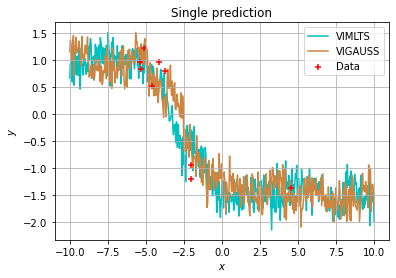

In [ ]:
mu_VIGAUSS = model_VIGAUSS.predict(xx)
y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()

mu_VIMLTS = model_VIMLTS.predict(xx)
y_pred_VIMLTS = tfp.distributions.Normal(mu_VIMLTS,sigma).sample()


plt.plot(xx,y_pred_VIMLTS,zorder=0, label=r'VIMLTS',color='c')
plt.plot(xx,y_pred_VIGAUSS,zorder=0,label=r'VIGAUSS',color='peru')
plt.scatter(x, y, marker='+',c='r',zorder=1, label=r'Data')
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Single prediction');

In [ ]:
# VIMLTS
y_pred_list = []

# VIGAUSS
y_pred_list_VIGAUSS = []

# Iterate over number of predictions
for i in tqdm.tqdm(range(num_predictions)):
    # VIMLTS
    mu_VIMLTS = model_VIMLTS.predict(xx)
    y_pred_VIMLTS = tfp.distributions.Normal(mu_VIMLTS,sigma).sample()
    y_pred_list.append(y_pred_VIMLTS)

    # VIGAUSS
    mu_VIGAUSS = model_VIGAUSS.predict(xx)
    y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()
    y_pred_list_VIGAUSS.append(y_pred_VIGAUSS)

# VIMLTS
y_preds = np.concatenate(y_pred_list, axis=1)
y_predictions_mean=np.mean(y_preds,axis=1)
y_predictions_2p5=np.quantile(y_preds,0.025,axis=1)
y_predictions_97p5=np.quantile(y_preds,0.975,axis=1)
y_predictions_50p0=np.quantile(y_preds,0.5,axis=1)

# VIGAUSS
y_preds_VIGAUSS = np.concatenate(y_pred_list_VIGAUSS, axis=1)
y_predictions_mean_VIGAUSS=np.mean(y_preds_VIGAUSS,axis=1)
y_predictions_2p5_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.025,axis=1)
y_predictions_97p5_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.975,axis=1)
y_predictions_50p0_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.5,axis=1)


100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s]


In [ ]:
np.savetxt('y_preds_VIGAUSS.csv', y_preds_VIGAUSS, delimiter=',')
np.savetxt('y_preds_VIMLTS.csv', y_preds, delimiter=',')
np.savetxt('xx.csv', xx, delimiter=',')

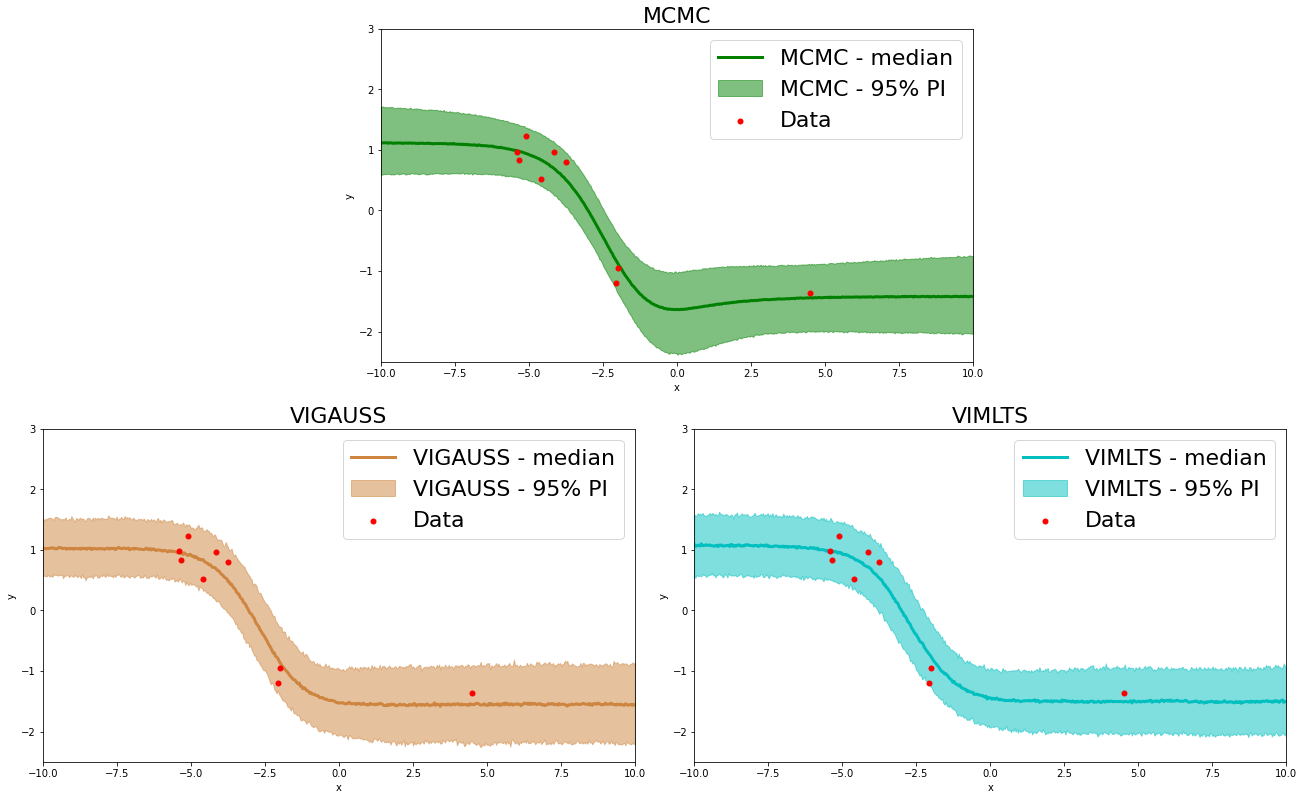

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(18,11))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, 1:3])
ax2 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[1, 2:4])

#fig.tight_layout(pad=0.0)
 
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22)  
plt.rc('legend', fontsize=22)

plt.rcParams['mathtext.fontset'] = 'cm'

linewidth=3

ax1.fill_between(xx.reshape(-1),samples_predictions_97p5,samples_predictions_2p5, color='g', alpha=0.5, label=(r"MCMC - 95% PI"))
ax1.plot(xx,samples_predictions_50p0, color='g' ,label=(r"MCMC - median"), linewidth=linewidth)
ax1.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth,  zorder=10)
ax1.set_xlim([-10,10])
ax1.set_ylim([-2.5,3])
ax1.set_xlabel(r'x')
ax1.set_ylabel(r'y')
ax1.set_title(r'MCMC')

ax1.legend()

ax2.fill_between(xx.reshape(-1),y_predictions_97p5_VIGAUSS,y_predictions_2p5_VIGAUSS, color='peru', alpha=0.5, label=(r"VIGAUSS - 95% PI"))
#ax2.plot(x_test_hello_world,vimlt_predictions_mean_hello_world, color='peru' ,label=(r"VIMLT - mean"))
ax2.plot(xx,y_predictions_50p0_VIGAUSS, color='peru' ,label=(r"VIGAUSS - median"), linewidth=linewidth)
ax2.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth, zorder=10)
ax2.set_xlim([-10,10])
ax2.set_ylim([-2.5,3])
ax2.set_xlabel(r'x')
ax2.set_ylabel(r'y')
ax2.set_title(r'VIGAUSS')
ax2.legend()


ax3.fill_between(xx.reshape(-1),y_predictions_97p5,y_predictions_2p5, color='c', alpha=0.5, label=(r"VIMLTS - 95% PI"))
#ax3.plot(x_test_hello_world,vimlts_predictions_mean_hello_world, color='c' ,label=(r"VIMLTS - mean"))
ax3.plot(xx,y_predictions_50p0, color='c' ,label=(r"VIMLTS - median"), linewidth=linewidth)
ax3.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth, zorder=10)
ax3.set_xlim([-10,10])
ax3.set_ylim([-2.5,3])
ax3.set_xlabel(r'x')
ax3.set_ylabel(r'y')
ax3.set_title(r'VIMLTS')
ax3.legend()

Evaluate the model with the NLL

In [ ]:
VIGAUSS_NLL_test_list = []
VIMLTS_NLL_test_list = []
num_evaluations=20

for i in range(num_evaluations):
    clear_output()
    print("round:\t",i,"/",num_evaluations)
    VIGAUSS_NLL_test_list.append(model_VIGAUSS.evaluate(x_test, y_test, batch_size=batch_size)[1])
    VIMLTS_NLL_test_list.append(model_VIMLTS.evaluate(x_test, y_test, batch_size=batch_size)[1])

VIGAUSS_NLL_test_mean=np.mean(VIGAUSS_NLL_test_list)
VIGAUSS_NLL_test_median=np.median(VIGAUSS_NLL_test_list)
VIMLTS_NLL_test_mean=np.mean(VIMLTS_NLL_test_list)
VIMLTS_NLL_test_median=np.median(VIMLTS_NLL_test_list)
print()
print()
print("VIGAUSS NLL test mean:\t\t",VIGAUSS_NLL_test_mean)
print("VIMLTS NLL test mean:\t\t",VIMLTS_NLL_test_mean)


print("VIGAUSS NLL test median:\t",VIGAUSS_NLL_test_median)
print("VIMLTS NLL test median:\t\t",VIMLTS_NLL_test_median)


round:	 19 / 20
112/112 [==============================] - 1s 11ms/step - loss: 188.8216 - neg_log_likelihood: 165.5133


VIGAUSS NLL test mean:		 181.87014923095703
VIMLTS NLL test mean:		 166.040966796875
VIGAUSS NLL test median:	 184.14199829101562
VIMLTS NLL test median:		 165.79376220703125


In [ ]:
samples_predictions_97p5.shape

(500,)

In [ ]:
num_predictions

1000

In [ ]:
x

array([[-5.41239  ],
       [-4.142973 ],
       [-5.100401 ],
       [-4.588446 ],
       [-2.0570369],
       [-2.0035906],
       [-3.7404475],
       [-5.344997 ],
       [ 4.506781 ]], dtype=float32)

In [ ]:
 %load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
x <- seq(0, 2*pi, length.out=50)
x

 [1] 0.0000000 0.1282283 0.2564565 0.3846848 0.5129131 0.6411414 0.7693696
 [8] 0.8975979 1.0258262 1.1540544 1.2822827 1.4105110 1.5387393 1.6669675
[15] 1.7951958 1.9234241 2.0516523 2.1798806 2.3081089 2.4363372 2.5645654
[22] 2.6927937 2.8210220 2.9492502 3.0774785 3.2057068 3.3339351 3.4621633
[29] 3.5903916 3.7186199 3.8468481 3.9750764 4.1033047 4.2315330 4.3597612
[36] 4.4879895 4.6162178 4.7444460 4.8726743 5.0009026 5.1291309 5.2573591
[43] 5.3855874 5.5138157 5.6420439 5.7702722 5.8985005 6.0267288 6.1549570
[50] 6.2831853


In [ ]:
xx.shape

(500, 1)